# 1\. Project Overview & Environment Setup

### Medical Image Classification POC (Ensemble AlexNet)

**Objective**
I aim to build a robust deep learning model to classify medical tissue images (Chorionic villi vs. Trophoblastic tissue) using a POC dataset stored in Google Drive.

**Methodology**

  * **EDA**: I analyze class balance and image properties before training.
  * **Modified AlexNet**: I utilize an AlexNet-based architecture enhanced with Batch Normalization.
  * **Ensemble Learning**: I combine predictions from 3 independent models (Soft Voting) to maximize generalization.
  * **Early Stopping**: I implement early stopping to prevent overfitting.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import glob
from tqdm import tqdm
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Set Random Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 4. Define Dataset Paths
DATA_ROOT = '/content/drive/MyDrive/POC_Dataset'
TRAIN_DIR = os.path.join(DATA_ROOT, 'Training')
TEST_DIR = os.path.join(DATA_ROOT, 'Testing')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2\. Exploratory Data Analysis (EDA)

I perform EDA to understand the dataset characteristics:

  * **Class Distribution**: Checking for data imbalance.
  * **Sample Visualization**: Inspecting image quality.
  * **Image Dimensions**: Verifying size distribution for resizing strategies.

/tmp/ipython-input-3193484643.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


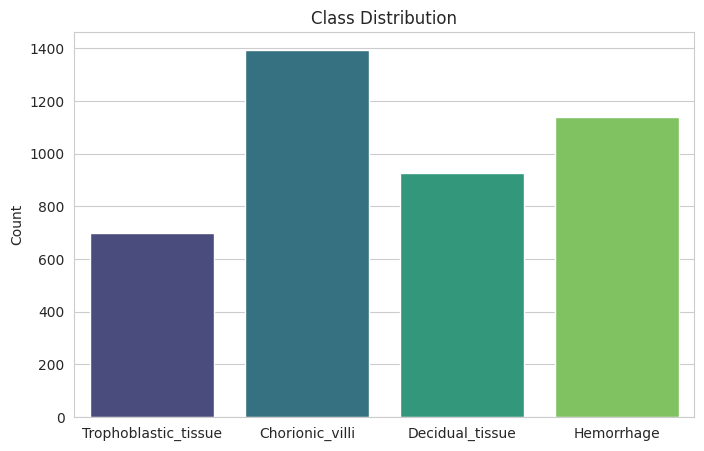

Count Details: {'Trophoblastic_tissue': 700, 'Chorionic_villi': 1391, 'Decidual_tissue': 926, 'Hemorrhage': 1138}

Sample Images:


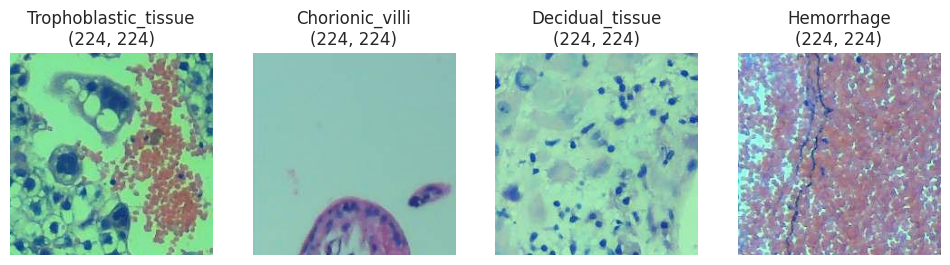

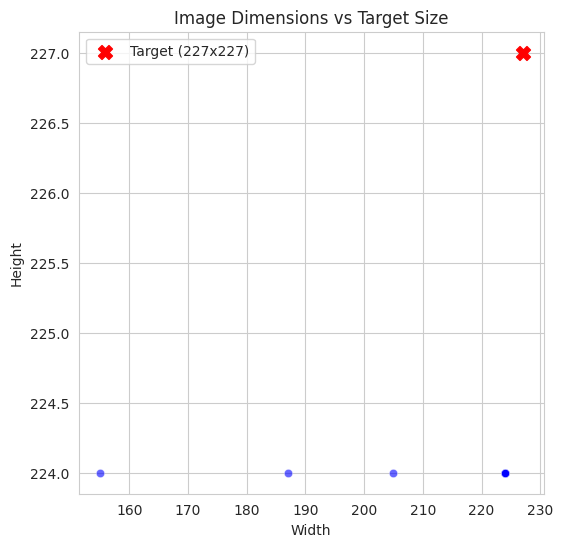

In [2]:
sns.set_style("whitegrid")

def perform_eda(data_dir):

    classes = os.listdir(data_dir)
    class_counts = {}
    sample_images = {}
    img_sizes = []

    # 1. Collect Data Info
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path): continue

        images = glob.glob(os.path.join(cls_path, "*.*"))
        class_counts[cls] = len(images)

        if images:
            sample_images[cls] = images[0]

        # Collect size info (Sample first 50 images)
        for img_path in images[:50]:
            try:
                with Image.open(img_path) as img:
                    img_sizes.append(img.size)
            except:
                pass

    # 2. Visualize Class Distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
    plt.title("Class Distribution")
    plt.ylabel("Count")
    plt.show()
    print(f"Count Details: {class_counts}")

    # 3. Visualize Sample Images
    print("\nSample Images:")
    fig, axes = plt.subplots(1, len(classes), figsize=(12, 5))
    if len(classes) == 1: axes = [axes]

    for idx, cls in enumerate(classes):
        if cls in sample_images:
            img = Image.open(sample_images[cls])
            axes[idx].imshow(img)
            axes[idx].set_title(f"{cls}\n{img.size}")
            axes[idx].axis('off')
    plt.show()

    # 4. Visualize Image Size Distribution
    if img_sizes:
        widths, heights = zip(*img_sizes)
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=widths, y=heights, alpha=0.6, color='blue')
        plt.scatter([227], [227], color='red', s=100, marker='X', label='Target (227x227)')
        plt.title("Image Dimensions vs Target Size")
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.legend()
        plt.show()

perform_eda(TRAIN_DIR)

# 3\. Data Preprocessing & Loading

I define hyperparameters and transformations:

  * **Augmentation**: Rotation, Horizontal/Vertical Flip.
  * **Splitting**: Train (80%) / Validation (20%).
  * **Batch Size**: 64

In [3]:
# Configuration
CONFIG = {
    'batch_size': 64,
    'learning_rate': 0.0001,
    'epochs': 50,
    'patience': 7,
    'ensemble_count': 3,
}

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loaders
full_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

classes = full_dataset.classes
num_classes = len(classes)
print(f"Classes: {classes} (Total: {num_classes})")

# Split Train/Val
num_train = len(full_dataset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_loader = DataLoader(full_dataset, batch_size=CONFIG['batch_size'], sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(full_dataset, batch_size=CONFIG['batch_size'], sampler=SubsetRandomSampler(valid_idx))
test_loader  = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"Data Ready | Train: {len(train_idx)} | Valid: {len(valid_idx)} | Test: {len(test_dataset)}")

Classes: ['Chorionic_villi', 'Decidual_tissue', 'Hemorrhage', 'Trophoblastic_tissue'] (Total: 4)
Data Ready | Train: 3324 | Valid: 831 | Test: 1511


# 4. Model Architecture

I designed the model architecture based on **AlexNet**, a pioneering Convolutional Neural Network (CNN). While retaining the core structural characteristics of AlexNet—specifically the **5 convolutional layers followed by 3 fully connected layers** and the use of **large kernel sizes (11x11, 5x5)** to capture spatial hierarchies—I introduced modern enhancements to optimize performance for this POC task.

**Key Architectural Features:**

* **Modified Convolutional Blocks (Batch Normalization)**:
    I replaced the outdated Local Response Normalization (LRN) from the original AlexNet with **Batch Normalization**. I applied `BatchNorm2d` after each convolutional layer. This modification stabilizes the learning process, significantly accelerates convergence, and reduces the model's sensitivity to weight initialization.

* **Regularization (Dropout)**:
    I incorporated **Dropout (p=0.5)** in the fully connected layers. This randomly zeros out neurons during training, which forces the network to learn more robust features and prevents overfitting on the limited dataset.

* **Adaptive Pooling**:
    I utilized `AdaptiveAvgPool2d((6, 6))` before the classifier. This ensures the feature map is always reduced to a fixed size regardless of minor input variations, making the transition to the dense layers seamless.

**Training Strategy: Early Stopping**

To further mitigate overfitting, I implemented an **Early Stopping** mechanism. I monitor the validation loss at every epoch; if the loss does not improve for a defined 'patience' period (7 epochs), training is halted. This ensures that I retain the model weights that achieved the best generalization performance, rather than the model at the final epoch.

In [4]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class EarlyStopping:
    def __init__(self, patience=7, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

# 5\. Training Loop

I train 3 independent models. The best weights for each model are saved locally.

In [5]:
def train_one_model(model_idx):

    model = AlexNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

    ckpt_path = f'model_{model_idx}_best.pt'
    early_stopping = EarlyStopping(patience=CONFIG['patience'], path=ckpt_path)

    best_val_acc = 0.0

    for epoch in range(CONFIG['epochs']):
        # Train
        model.train()
        train_loss = 0.0

        loop = tqdm(train_loader, leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_description(f"Epoch {epoch+1}")

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(valid_loader)
        val_acc = 100 * correct / total

        print(f"  Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("  Early stopping triggered.")
            break

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    model.load_state_dict(torch.load(ckpt_path))
    print(f"[Model {model_idx+1}]:  Best Validation Acc: {best_val_acc:.2f}%")
    return model, best_val_acc

# 6\. Final Evaluation

I evaluate the performance on the Test Set using **Soft Voting Ensemble**.


In [6]:
# 1. Train All Models
models_list = []
results_log = []

for i in range(CONFIG['ensemble_count']):
    trained_model, best_acc = train_one_model(i)
    models_list.append(trained_model)
    results_log.append({'Model': f'Model {i+1}', 'Accuracy': f'{best_acc:.2f}% (Val)'})

# 2. Ensemble Evaluation
print("\n[Ensemble Evaluation on Test Set]")
correct = 0
total = 0

for model in models_list:
    model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        ensemble_logits = torch.zeros(inputs.size(0), num_classes).to(device)

        for model in models_list:
            outputs = model(inputs)
            ensemble_logits += outputs

        _, predicted = torch.max(ensemble_logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

ensemble_acc = 100 * correct / total
results_log.append({'Model': 'Ensemble (Final)', 'Accuracy': f'{ensemble_acc:.2f}% (Test)'})

# 3. Display Results
df_results = pd.DataFrame(results_log)

print("POC FINAL EXPERIMENT RESULTS")
print(df_results)

  Epoch 01 | Train Loss: 1.0576 | Val Loss: 0.8117 | Val Acc: 66.06%


  Epoch 02 | Train Loss: 0.6858 | Val Loss: 0.5263 | Val Acc: 80.26%


  Epoch 03 | Train Loss: 0.5405 | Val Loss: 0.3922 | Val Acc: 86.28%


  Epoch 04 | Train Loss: 0.4567 | Val Loss: 0.4390 | Val Acc: 83.39%


  Epoch 05 | Train Loss: 0.4284 | Val Loss: 0.3415 | Val Acc: 88.69%


  Epoch 06 | Train Loss: 0.3883 | Val Loss: 0.3196 | Val Acc: 87.24%


  Epoch 07 | Train Loss: 0.3467 | Val Loss: 0.3423 | Val Acc: 88.21%


  Epoch 08 | Train Loss: 0.3446 | Val Loss: 0.3141 | Val Acc: 88.45%


  Epoch 09 | Train Loss: 0.3101 | Val Loss: 0.3904 | Val Acc: 86.76%


  Epoch 10 | Train Loss: 0.3249 | Val Loss: 0.2934 | Val Acc: 90.01%


  Epoch 11 | Train Loss: 0.2908 | Val Loss: 0.3161 | Val Acc: 88.21%


  Epoch 12 | Train Loss: 0.2649 | Val Loss: 0.2484 | Val Acc: 90.97%


  Epoch 13 | Train Loss: 0.2440 | Val Loss: 0.2888 | Val Acc: 89.65%


  Epoch 14 | Train Loss: 0.2744 | Val Loss: 0.2371 | Val Acc: 91.46%


  Epoch 15 | Train Loss: 0.2677 | Val Loss: 0.2743 | Val Acc: 90.61%


  Epoch 16 | Train Loss: 0.2613 | Val Loss: 0.2828 | Val Acc: 91.34%


  Epoch 17 | Train Loss: 0.2323 | Val Loss: 0.2757 | Val Acc: 89.41%


  Epoch 18 | Train Loss: 0.2490 | Val Loss: 0.2601 | Val Acc: 92.18%


  Epoch 19 | Train Loss: 0.2232 | Val Loss: 0.2401 | Val Acc: 90.97%


  Epoch 20 | Train Loss: 0.2204 | Val Loss: 0.2314 | Val Acc: 92.30%


  Epoch 21 | Train Loss: 0.1966 | Val Loss: 0.2253 | Val Acc: 91.94%


  Epoch 22 | Train Loss: 0.2034 | Val Loss: 0.1903 | Val Acc: 93.38%


  Epoch 23 | Train Loss: 0.2080 | Val Loss: 0.2670 | Val Acc: 90.37%


  Epoch 24 | Train Loss: 0.1907 | Val Loss: 0.2714 | Val Acc: 90.01%


  Epoch 25 | Train Loss: 0.1971 | Val Loss: 0.2751 | Val Acc: 90.61%


  Epoch 26 | Train Loss: 0.1871 | Val Loss: 0.3038 | Val Acc: 90.97%


  Epoch 27 | Train Loss: 0.1844 | Val Loss: 0.2215 | Val Acc: 93.14%


  Epoch 28 | Train Loss: 0.1628 | Val Loss: 0.2618 | Val Acc: 90.49%


  Epoch 29 | Train Loss: 0.1749 | Val Loss: 0.3887 | Val Acc: 87.61%
  Early stopping triggered.
[Model 1]:  Best Validation Acc: 93.38%


  Epoch 01 | Train Loss: 1.0098 | Val Loss: 0.6978 | Val Acc: 73.77%


  Epoch 02 | Train Loss: 0.6486 | Val Loss: 0.7283 | Val Acc: 71.72%


  Epoch 03 | Train Loss: 0.5398 | Val Loss: 0.4416 | Val Acc: 84.84%


  Epoch 04 | Train Loss: 0.4558 | Val Loss: 0.4001 | Val Acc: 85.08%


  Epoch 05 | Train Loss: 0.4257 | Val Loss: 0.3286 | Val Acc: 87.97%


  Epoch 06 | Train Loss: 0.4120 | Val Loss: 0.3380 | Val Acc: 88.33%


  Epoch 07 | Train Loss: 0.3773 | Val Loss: 0.3148 | Val Acc: 88.33%


  Epoch 08 | Train Loss: 0.3549 | Val Loss: 0.3020 | Val Acc: 90.01%


  Epoch 09 | Train Loss: 0.3094 | Val Loss: 0.3124 | Val Acc: 87.85%


  Epoch 10 | Train Loss: 0.3085 | Val Loss: 0.2967 | Val Acc: 89.77%


  Epoch 11 | Train Loss: 0.2870 | Val Loss: 0.3699 | Val Acc: 85.92%


  Epoch 12 | Train Loss: 0.3059 | Val Loss: 0.2456 | Val Acc: 91.10%


  Epoch 13 | Train Loss: 0.2618 | Val Loss: 0.2723 | Val Acc: 89.53%


  Epoch 14 | Train Loss: 0.2616 | Val Loss: 0.3148 | Val Acc: 90.13%


  Epoch 15 | Train Loss: 0.2563 | Val Loss: 0.2393 | Val Acc: 91.82%


  Epoch 16 | Train Loss: 0.2406 | Val Loss: 0.2884 | Val Acc: 90.01%


  Epoch 17 | Train Loss: 0.2632 | Val Loss: 0.3405 | Val Acc: 87.85%


  Epoch 18 | Train Loss: 0.2444 | Val Loss: 0.2498 | Val Acc: 90.73%


  Epoch 19 | Train Loss: 0.2438 | Val Loss: 0.2359 | Val Acc: 92.18%


  Epoch 20 | Train Loss: 0.2173 | Val Loss: 0.2767 | Val Acc: 91.22%


  Epoch 21 | Train Loss: 0.2151 | Val Loss: 0.2066 | Val Acc: 92.78%


  Epoch 22 | Train Loss: 0.1903 | Val Loss: 0.2496 | Val Acc: 90.01%


  Epoch 23 | Train Loss: 0.2020 | Val Loss: 0.2652 | Val Acc: 90.25%


  Epoch 24 | Train Loss: 0.2058 | Val Loss: 0.2243 | Val Acc: 93.02%


  Epoch 25 | Train Loss: 0.1808 | Val Loss: 0.2064 | Val Acc: 92.78%


  Epoch 26 | Train Loss: 0.1916 | Val Loss: 0.2580 | Val Acc: 90.01%


  Epoch 27 | Train Loss: 0.1916 | Val Loss: 0.2747 | Val Acc: 91.22%


  Epoch 28 | Train Loss: 0.1890 | Val Loss: 0.2344 | Val Acc: 91.58%


  Epoch 29 | Train Loss: 0.1701 | Val Loss: 0.2006 | Val Acc: 93.26%


  Epoch 30 | Train Loss: 0.1605 | Val Loss: 0.2260 | Val Acc: 92.18%


  Epoch 31 | Train Loss: 0.1533 | Val Loss: 0.2758 | Val Acc: 91.82%


  Epoch 32 | Train Loss: 0.1761 | Val Loss: 0.2392 | Val Acc: 91.70%


  Epoch 33 | Train Loss: 0.1778 | Val Loss: 0.2044 | Val Acc: 93.14%


  Epoch 34 | Train Loss: 0.1807 | Val Loss: 0.2168 | Val Acc: 92.66%


  Epoch 35 | Train Loss: 0.1594 | Val Loss: 0.2401 | Val Acc: 92.30%


  Epoch 36 | Train Loss: 0.1438 | Val Loss: 0.3272 | Val Acc: 90.01%
  Early stopping triggered.
[Model 2]:  Best Validation Acc: 93.26%


  Epoch 01 | Train Loss: 1.0237 | Val Loss: 0.7967 | Val Acc: 67.63%


  Epoch 02 | Train Loss: 0.6699 | Val Loss: 0.5007 | Val Acc: 82.19%


  Epoch 03 | Train Loss: 0.5258 | Val Loss: 0.6354 | Val Acc: 77.62%


  Epoch 04 | Train Loss: 0.4587 | Val Loss: 0.4393 | Val Acc: 83.51%


  Epoch 05 | Train Loss: 0.4132 | Val Loss: 0.4111 | Val Acc: 85.56%


  Epoch 06 | Train Loss: 0.3767 | Val Loss: 0.3288 | Val Acc: 88.33%


  Epoch 07 | Train Loss: 0.3714 | Val Loss: 0.3070 | Val Acc: 90.25%


  Epoch 08 | Train Loss: 0.3285 | Val Loss: 0.3091 | Val Acc: 90.01%


  Epoch 09 | Train Loss: 0.3345 | Val Loss: 0.3840 | Val Acc: 86.88%


  Epoch 10 | Train Loss: 0.3073 | Val Loss: 0.5094 | Val Acc: 83.15%


  Epoch 11 | Train Loss: 0.2809 | Val Loss: 0.2303 | Val Acc: 92.30%


  Epoch 12 | Train Loss: 0.3230 | Val Loss: 0.2850 | Val Acc: 89.41%


  Epoch 13 | Train Loss: 0.2522 | Val Loss: 0.2816 | Val Acc: 88.21%


  Epoch 14 | Train Loss: 0.2437 | Val Loss: 0.2385 | Val Acc: 91.70%


  Epoch 15 | Train Loss: 0.2567 | Val Loss: 0.3102 | Val Acc: 89.41%


  Epoch 16 | Train Loss: 0.2355 | Val Loss: 0.2515 | Val Acc: 92.06%


  Epoch 17 | Train Loss: 0.2308 | Val Loss: 0.3425 | Val Acc: 88.45%


  Epoch 18 | Train Loss: 0.2402 | Val Loss: 0.2744 | Val Acc: 91.34%
  Early stopping triggered.
[Model 3]:  Best Validation Acc: 92.30%

[Ensemble Evaluation on Test Set]
POC FINAL EXPERIMENT RESULTS
              Model       Accuracy
0           Model 1   93.38% (Val)
1           Model 2   93.26% (Val)
2           Model 3   92.30% (Val)
3  Ensemble (Final)  76.84% (Test)
